# Análisis de modelo: CML, R², VIF

In [ ]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

In [ ]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python3 --version
import metnum

## Explorando los datos

In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn.metrics as mtr
import matplotlib.pyplot as plt

datos = pd.read_csv("../../dataset-tp3/expectativa_de_vida.csv")

In [ ]:
datos

# Análisis

In [ ]:
def analisis_VIF(datos, etiquetas) :
    print ("VIF:")
    for etiqueta in etiquetas :
        demas_etiquetas = etiquetas.copy()
        demas_etiquetas.remove(etiqueta)
        r2_sin_ajuste = analisis(datos, demas_etiquetas, etiqueta, True)
        vif = 1/(1-r2_sin_ajuste)
        print('\t', "%+.6f" % vif, '\t', etiqueta)
        
#def analisis_COOK(datos, etiquetas, resultados, residuos) :
#    ecm = 
#    for fila in range(0, datos.shape[0]) :
        

In [ ]:
def analisis(datos, etiquetas, resultados, en_subanalisis_vif=False) :
    expectativas = datos[resultados].values.reshape(-1, 1)
    
    # Elegir los predictores a usar de entre los datos
    predictores = datos[etiquetas].values
    cantidad_predictores = predictores.shape[1]
    
    # Verificar que cada muestra de predictores tiene un resultado asociado
    cantidad_muestras = predictores.shape[0]
    assert(cantidad_muestras == expectativas.shape[0])
    if (not en_subanalisis_vif) :
        print("Países:", cantidad_muestras)
        print()
    
    # Agregar columna de 1's para el coeficiente constante
    predictores_con_constante = np.append(predictores.copy(), np.ones((cantidad_muestras,1)), axis=1)
    
    # Calcular coeficientes óptimos según Cuadrados Mínimos Lineales (C++)
    coeficientes = metnum.CML().solve(predictores_con_constante, expectativas)
    if (not en_subanalisis_vif) :
        print("COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):")
        print('\t',"Constante:",coeficientes[cantidad_predictores])
        for i in range(cantidad_predictores) :
            print('\t', "%+.6f" % coeficientes[i], '\t', etiquetas[i])
        print()
        
        
    
    # Calcular las predicciones y residuos
    predicciones = np.zeros(cantidad_muestras)
    residuos = np.zeros(cantidad_muestras)
    for i in range(cantidad_muestras) :
        predicciones[i] = np.dot(predictores_con_constante[i], coeficientes)
        residuos[i] = predicciones[i] - expectativas[i]
    
    
    # Calcular R² y R² ajustado
    r2_sin_ajuste = mtr.r2_score(expectativas, predicciones)
    r2_con_ajuste = 1-(1-r2_sin_ajuste)*(cantidad_muestras-1)/(cantidad_muestras-cantidad_predictores-1)
    if (en_subanalisis_vif) : return r2_sin_ajuste
    print("VARIABILIDAD EXPLICADA")
    print('\t',"R² sin ajuste:",r2_sin_ajuste)
    print('\t',"R² con ajuste:",r2_con_ajuste)
    print()
    
    
    # Calcular las muestras estandarizadas según cada predictor
    predictores_estandarizados = predictores.copy()
    for i in range(cantidad_predictores) :
        # Restar media
        predictores_estandarizados[:,i] -= np.mean(predictores_estandarizados[:,i])
        # Dividir por desvío estandar, en caso de no ser nulo
        if (np.std(predictores_estandarizados[:,i]) != 0) :
            predictores_estandarizados[:,i] /= np.std(predictores_estandarizados[:,i])
    
    # Calcular la significancia relativa entre coeficientes
    coeficientes_relativos = metnum.CML().solve(predictores_estandarizados, expectativas)
    print("COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):")
    for i in range(cantidad_predictores) :
        print('\t', "%+.6f" % coeficientes_relativos[i], '\t', etiquetas[i])
    print()
    
    analisis_VIF(datos, etiquetas)
    
    # Gráfico "residuo vs predicción" (normalizado)
    residuos_estandarizados = residuos.copy()/np.std(residuos)
    for i in range(cantidad_muestras) :
        # Restar media
        residuos_estandarizados[i] -= np.mean(residuos)
        # Dividir por desvío estandar
        residuos_estandarizados[i] /= np.std(residuos)
    plt.plot(predicciones, residuos_estandarizados, 'x')
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos estandarizados")
    plt.hlines(0, xmin=min(predicciones), xmax=max(predicciones))
    plt.title("Residual plot")
    plt.show()
    
    print("--------------------------------------------------------------------------------------------------------------------------------")
    #analisis_COOK(datos, etiquetas, resultados, residuos)
    
    #return coeficientes, r2_con_ajuste

# Sanitización de dataset

In [ ]:
def completar_medias(originales) :
    completados = datos.copy()[:]
    for columna in completados.columns :
        if (columna == "Country" or columna == "Status") : continue
        media = np.nanmean(completados[columna])
        es_NaN = completados[columna].isnull()
        completados[columna][es_NaN] = media
    return completados


def completar_medianas(originales) :
    completados = datos.copy()[:]
    for columna in completados.columns :
        if (columna == "Country" or columna == "Status") : continue
        mediana = np.nanmedian(completados[columna])
        es_NaN = completados[columna].isnull()
        completados[columna][es_NaN] = mediana
    return completados


def completar_medianas_segregado(originales) :
    completados = datos.copy()[:]
    for columna in completados.columns :
        if (columna != "Country" and columna != "Status") :
            mediana_desarrollados = np.nanmedian(datos[datos["Status"] == "Developed"][columna])
            mediana_en_desarrollo = np.nanmedian(datos[datos["Status"] == "Developing"][columna])

            es_NaN_desarrollados = datos[columna].isnull() * datos["Status"] == "Developed"
            es_NaN_en_desarrollo = datos[columna].isnull() * datos["Status"] == "Developing"
            
            nueva_columna = completados[columna].copy()
            nueva_columna[es_NaN_en_desarrollo] = mediana_en_desarrollo
            nueva_columna[es_NaN_desarrollados] = mediana_desarrollados
            completados[columna] = nueva_columna
        
    return completados
            
            
datos_con_medias = completar_medias(datos)
datos_con_medianas = completar_medianas(datos)
datos_con_medianas_segregadas = completar_medianas_segregado(datos)

In [ ]:
# Estaban así
datos[datos["Schooling"].isnull()][["Country", "Schooling", "Status"]]

In [ ]:
# Aber si funcó
datos_con_medianas_segregadas[datos["Schooling"].isnull()][["Country", "Schooling", "Status"]]

# Eleción de dataset

### Todos los predictores originales

In [ ]:
analisis(datos_con_medias, ['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')
analisis(datos_con_medianas, ['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

### Un predictor de cada grupo correlacionado

In [ ]:
analisis(datos_con_medias, ['Adult Mortality', 'infant deaths', 'Alcohol', 'Hepatitis B', 'BMI', 'Total expenditure', 'HIV/AIDS', 'GDP', 'Schooling', 'Poisoning'], 'Life expectancy')
analisis(datos_con_medianas, ['Adult Mortality', 'infant deaths', 'Alcohol', 'Hepatitis B', 'BMI', 'Total expenditure', 'HIV/AIDS', 'GDP', 'Schooling', 'Poisoning'], 'Life expectancy')
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'infant deaths', 'Alcohol', 'Hepatitis B', 'BMI', 'Total expenditure', 'HIV/AIDS', 'GDP', 'Schooling', 'Poisoning'], 'Life expectancy')

# Backwards selection solo mirando los VIF
Elegimos un solo dataset para este análisis, los resultados son muy similares en todos 

In [ ]:
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [ ]:
# infant deaths

In [ ]:
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [ ]:
# thinness 5-9 years

In [ ]:
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [ ]:
# under-five deaths

In [ ]:
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [ ]:
# Polio

In [ ]:
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [ ]:
# GDP

In [ ]:
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [ ]:
# Schooling

In [ ]:
analisis(datos_con_medianas_segregadas, ['Adult Mortality', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Poisoning'], 'Life expectancy')

In [ ]:
# ADULT MORTALITY

Tenemos un modelo con todos los VIF < 5, con coeficiente dominante ADULT MORTALITY.

Pero esta variable no es accionable, por lo que decidimos no considerarla desde el principio.

# Backwards selection sin ADULT MORTALITY

In [ ]:
analisis(datos_con_medianas_segregadas, ['infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [ ]:
# infant deaths

In [ ]:
analisis(datos_con_medianas_segregadas, ['Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [ ]:
# thinness 5-9 years

In [ ]:
analisis(datos_con_medianas_segregadas, ['Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [ ]:
# under-five deaths

In [ ]:
analisis(datos_con_medianas_segregadas, ['Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Polio', 'Total expenditure', 'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [ ]:
# Diphtheria

In [ ]:
analisis(datos_con_medianas_segregadas, ['Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Polio', 'Total expenditure', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [ ]:
# GDP

In [ ]:
analisis(datos_con_medianas_segregadas, ['Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Polio', 'Total expenditure', 'HIV/AIDS', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Schooling', 'Poisoning'], 'Life expectancy')

In [ ]:
# Schooling

In [ ]:
analisis(datos_con_medianas_segregadas, ['Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Polio', 'Total expenditure', 'HIV/AIDS', 'Population', 'thinness  1-19 years', 'Income composition of resources', 'Poisoning'], 'Life expectancy')

Tenemos un modelo con todos los VIF < 5, con coeficiente dominante HIV/AIDS (y POLIO muy pegadito).

Con este análisis llegamos a un grupo de predictores donde por lo menos hay un elemento de cada uno de los grupos de correlación obtenidos en el EDA.

Pero:

POPULATION no es directamente accionable, porfa.

ALCOHOL es el coeficiente que menor aporta al modelo, además de ser confounding. ("Más se vive, más se bebe")

In [ ]:
analisis(datos_con_medianas_segregadas, ['percentage expenditure', 'Hepatitis B', 'Measles', 'BMI', 'Polio', 'Total expenditure', 'HIV/AIDS', 'thinness  1-19 years', 'Income composition of resources', 'Poisoning'], 'Life expectancy')

Sabemos que POLIO y HEPATITIS B están correlacionados. Optamos por sacar la segunda dado que tiene un menor coeficiente.

In [ ]:
analisis(datos_con_medianas_segregadas, ['percentage expenditure', 'Measles', 'BMI', 'Polio', 'Total expenditure', 'HIV/AIDS', 'thinness  1-19 years', 'Income composition of resources', 'Poisoning'], 'Life expectancy')

En el nuevo modelo Measels se vuelve insignificante (por su coeficiente)

In [ ]:
analisis(datos_con_medianas_segregadas, ['percentage expenditure', 'BMI', 'Polio', 'Total expenditure', 'HIV/AIDS', 'thinness  1-19 years', 'Income composition of resources', 'Poisoning'], 'Life expectancy')

Con este último modelo conseguimos un R² (ajustado) relativamente alto, con valores razonablemente bajos de VIF, utilizando pocas variables simples, es decir, cada regresor se basa en un único dato.

# Variables compuestas

Dado que en la eliminación quizás descartamos datos potencialmente relevantes en cada grupo correlacionado, procedemos a intentar recuperarlos incorporandolos en regresores compuestos.

Probamos: "Polio + Diphtheria", "Polio + Hepatitis B" y "Polio + Diphtheria + Hepatitis B"

In [ ]:
if not ("inmunizacion" in datos_con_medianas_segregadas.columns):
    datos_con_medianas_segregadas.insert(0, "inmunizacion", 0)

datos_con_medianas_segregadas["inmunizacion"] = datos_con_medianas_segregadas["Polio"] + datos_con_medianas_segregadas["Diphtheria"]

In [ ]:
analisis(datos_con_medianas_segregadas, ['percentage expenditure', 'BMI', 'inmunizacion', 'Total expenditure', 'HIV/AIDS', 'thinness  1-19 years', 'Income composition of resources', 'Poisoning'], 'Life expectancy')

La mejor opción resultó ser la primera

Probamos: "percentage expenditure + GDP" (estandarizando)

In [ ]:
if not ("ricachosidad" in datos_con_medianas_segregadas.columns):
    datos_con_medianas_segregadas.insert(0, "ricachosidad", 0)
    datos_con_medianas_segregadas.insert(0, "standard_GDP", 0)
    datos_con_medianas_segregadas.insert(0, "standard_expenditure", 0)

media = np.mean(datos_con_medianas_segregadas["GDP"])
std = np.std(datos_con_medianas_segregadas["GDP"])
datos_con_medianas_segregadas["standard_GDP"] = (datos_con_medianas_segregadas["GDP"]-media)/std

media = np.mean(datos_con_medianas_segregadas["percentage expenditure"])
std = np.std(datos_con_medianas_segregadas["percentage expenditure"])
datos_con_medianas_segregadas["standard_expenditure"] = (datos_con_medianas_segregadas["percentage expenditure"]-media)/std

datos_con_medianas_segregadas["ricachosidad"] = datos_con_medianas_segregadas["standard_GDP"] + datos_con_medianas_segregadas["standard_expenditure"]

No aporta

Probamos: "thinness  1-19 years + BMI" (estandarizando)

In [ ]:
if not ("pachonsidad" in datos_con_medianas_segregadas.columns):
    datos_con_medianas_segregadas.insert(0, "pachonsidad", 0)
    datos_con_medianas_segregadas.insert(0, "standard_BMI", 0)
    datos_con_medianas_segregadas.insert(0, "standard_thinness", 0)

media = np.mean(datos_con_medianas_segregadas["BMI"])
std = np.std(datos_con_medianas_segregadas["BMI"])
datos_con_medianas_segregadas["standard_BMI"] = (datos_con_medianas_segregadas["BMI"]-media)/std

media = np.mean(datos_con_medianas_segregadas["thinness  1-19 years"])
std = np.std(datos_con_medianas_segregadas["thinness  1-19 years"])
datos_con_medianas_segregadas["standard_thinness"] = (datos_con_medianas_segregadas["thinness  1-19 years"]-media)/std

datos_con_medianas_segregadas["pachonsidad"] = datos_con_medianas_segregadas["standard_thinness"] + datos_con_medianas_segregadas["standard_thinness"]

No rinde

Probamos combinar los "thinness"

In [ ]:
if not ("thinness" in datos_con_medianas_segregadas.columns):
    datos_con_medianas_segregadas.insert(0, "thinness", 0)

datos_con_medianas_segregadas["thinness"] = datos_con_medianas_segregadas["thinness  1-19 years"] + datos_con_medianas_segregadas["thinness 5-9 years"]

Países: 183

COEFICIENTES SIN ESTANDARIZACIÓN (para predecir resultados):
	 Constante: [42.52951802]
	 +0.000950 	 percentage expenditure
	 +0.121573 	 BMI
	 +0.075811 	 inmunizacion
	 +0.148966 	 Total expenditure
	 -0.668396 	 HIV/AIDS
	 +0.031877 	 thinness
	 +15.165241 	 Income composition of resources
	 -0.590706 	 Poisoning

VARIABILIDAD EXPLICADA
	 R² sin ajuste: 0.8647357754645306
	 R² con ajuste: 0.8585167306583021

COEFICIENTES CON ESTANDARIZACIÓN (para comparar significancia):
	 +1.403417 	 percentage expenditure
	 +1.918386 	 BMI
	 +2.424878 	 inmunizacion
	 +0.284124 	 Total expenditure
	 -2.964647 	 HIV/AIDS
	 +0.260765 	 thinness
	 +2.738735 	 Income composition of resources
	 -0.748393 	 Poisoning

VIF:
	 +1.513289 	 percentage expenditure
	 +3.017489 	 BMI
	 +1.605902 	 inmunizacion
	 +1.270488 	 Total expenditure
	 +1.230722 	 HIV/AIDS
	 +2.176109 	 thinness
	 +2.655295 	 Income composition of resources
	 +1.155368 	 Poisoning


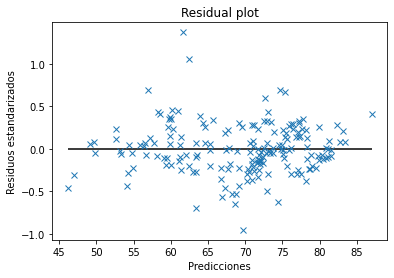

--------------------------------------------------------------------------------------------------------------------------------


In [196]:
analisis(datos_con_medianas_segregadas, ['percentage expenditure', 'BMI', 'inmunizacion', 'Total expenditure', 'HIV/AIDS', 'thinness', 'Income composition of resources', 'Poisoning'], 'Life expectancy')

Sirve un poco

# Llegamos a un modelo relativamente bueno
8 variables

R² con ajuste: 0.8585167

:)